# Data and Web Mining
## Kaggle ft Child Institute: problematic internet use 
alleneremo e metteremo a confronto due modelli. uno ad albero e uno basato su rete neurale.

In [135]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif # vedere correlazioni tra feature e label


# Preparazione dati : 
1) split train & test 

2) eliminare le colonne del train cui c'è una quantità di NaN maggiore del 50% 

3) fare correlazione fra le colonne ed eliminare tutte le colonne con una forte correlazione fra di loro e una bassa correlazione con il target .
**Filter approaches**: Features are selected before the data mining algorithm is run. The specific filtering method might be independent of the learning algorithm. For instance, we may remove features with little correlation with the target, or remove a feature that is highly correlated with another one (it is redundant).

4) Usare un wrapper Approach per una semiconferma (va bene anche un modello lineare multivariato).
**Wrapper approaches**: Feature are selected on the basis of their contribution, and the contribution is measured after running the algorithm as a black-box.

In [174]:
SEED = 42 # global random seed for reproducibility
np.random.seed(SEED)

# read data : 
data = pd.read_csv("../data/train.csv") # dataset intero

Y = data['sii']     # classe da predire

X = data.drop(columns=['id','sii'])     # features

# non ha senso lasciare righe in cui la label non si conosce. è supervised learning: ogni riga deve avere la sua classificazione
X = X[Y.notnull()]
Y = Y[Y.notnull()]
print("X shape", X.shape)
X

X shape (2736, 80)


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0
5,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,...,3.0,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,25.0,...,0.0,2.0,2.0,1.0,22.0,Fall,41.0,58.0,Fall,2.0
3954,Summer,7,1,NaN,NaN,Summer,13.927006,48.5,46.6,23.0,...,3.0,3.0,3.0,0.0,33.0,Summer,48.0,67.0,Summer,0.0
3955,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,...,2.0,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0
3957,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,NaN,...,1.0,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0


In [ ]:
# split train & test : 
from sklearn.model_selection import train_test_split

# slip train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)

# split train & val 
X_train,X_val , y_train, y_val = train_test_split(
    X_train,y_train,test_size = 0.2,random_state=SEED
)

vado a contare il numero di missing values per ogni colonna presente in train. Voglio eliminare tutte le colonne che hanno più del 50% di missing values.
Sulle colonne selezionate vado fare la matrice di correlazione e vado ad eliminare le colonne rimaste che possono risultare ridondandi.

In [138]:
num_of_instances , num_of_columns = X_train.shape
num_of_instances


columns_to_keep = X_train.isnull().sum().sort_values(ascending=False)  < (num_of_instances//2)
columns_to_keep

PAQ_A-Season                    False
PAQ_A-PAQ_A_Total               False
Physical-Waist_Circumference    False
Fitness_Endurance-Time_Mins     False
Fitness_Endurance-Time_Sec      False
                                ...  
Basic_Demos-Sex                  True
PCIAT-PCIAT_01                   True
PCIAT-Season                     True
PCIAT-PCIAT_02                   True
PCIAT-PCIAT_Total                True
Length: 80, dtype: bool

In [139]:
num_of_instances , num_of_columns = X_train.shape
num_of_instances

X_train = X_train.loc[:, columns_to_keep]
X_train.columns

Index(['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-Season',
       'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
       'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'PCIAT-Season',
       'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
       'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08',
 

In [140]:
# mapping stagioni
season_map = {
    # il mapping darà NaN quando incontra NaN, quindi viene gestito in automatico
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

# colonne che terminano in "-Season"

season_cols = [col for col in X_train.columns if col.endswith('Season')]

for col in season_cols:
    X_train[col] = X_train[col].map(season_map)



Voglio calcolare la matrice delle correlazioni in modo da porter vedere quali di queste risultano ridondanti e poco correlate con il Sii.

In [141]:
X_train.corr()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,...,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
Basic_Demos-Enroll_Season,1.000000,-0.022937,0.014801,-0.299809,-0.033591,0.298180,-0.038912,-0.043278,-0.015948,-0.015905,...,-0.009726,-0.009035,-0.017690,0.010507,-0.011213,0.277601,0.052060,0.051602,0.951792,-0.023861
Basic_Demos-Age,-0.022937,1.000000,0.073780,0.033083,-0.031213,-0.013270,0.492418,0.892366,0.766513,0.127898,...,0.284687,0.171325,0.289424,0.279128,0.414401,-0.063068,0.024425,0.026186,-0.005963,0.419653
Basic_Demos-Sex,0.014801,0.073780,1.000000,-0.010634,0.127421,0.001442,0.048227,-0.000383,0.015131,0.014095,...,-0.095151,-0.095106,-0.093957,-0.049889,-0.070898,0.004256,-0.019773,-0.018837,0.021119,0.007362
CGAS-Season,-0.299809,0.033083,-0.010634,1.000000,0.048655,-0.014046,0.034231,0.025352,0.026951,-0.033662,...,0.006437,-0.024527,0.015819,0.017289,0.009640,-0.039020,-0.032027,-0.031174,-0.279754,0.002525
CGAS-CGAS_Score,-0.033591,-0.031213,0.127421,0.048655,1.000000,-0.000976,-0.063280,-0.020862,-0.054213,-0.007124,...,-0.047389,-0.088561,-0.059145,-0.070745,-0.074815,0.026805,-0.155961,-0.157248,-0.029538,-0.092705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SDS-Season,0.277601,-0.063068,0.004256,-0.039020,0.026805,0.663702,-0.069474,-0.055468,-0.061853,-0.017809,...,-0.026315,-0.036517,-0.022052,-0.008084,-0.055775,1.000000,0.010393,0.011840,0.270959,-0.027156
SDS-SDS_Total_Raw,0.052060,0.024425,-0.019773,-0.032027,-0.155961,-0.004516,0.070434,0.030047,0.053555,0.007284,...,0.173363,0.249385,0.185786,0.214800,0.246217,0.010393,1.000000,0.998681,0.039856,0.073435
SDS-SDS_Total_T,0.051602,0.026186,-0.018837,-0.031174,-0.157248,-0.002278,0.070680,0.031879,0.054202,0.006937,...,0.176692,0.250551,0.188279,0.216795,0.248477,0.011840,0.998681,1.000000,0.040015,0.075366
PreInt_EduHx-Season,0.951792,-0.005963,0.021119,-0.279754,-0.029538,0.302197,-0.029098,-0.028557,-0.001586,-0.012800,...,-0.010542,-0.012766,-0.030641,0.000806,-0.011515,0.270959,0.039856,0.040015,1.000000,-0.027621


In [142]:
X_train.shape

(1750, 69)

Ricalcolo la matrice di correlazione e vado a rimuovere le colonne che sono meno correlate con la risposta

In [143]:

# 1. Inserisci il target come colonna temporanea
X_temp = X_train.copy()
X_temp.insert(0, column="Sii", value=y_train)

# 2. Calcola la matrice di correlazione assoluta
corr_matrix = X_temp.corr().abs()

# 3. Estrai correlazione col target (riga "Sii", escludendo "Sii" stesso)
target_corr = corr_matrix.loc["Sii"].drop("Sii")

useful_features = target_corr[(target_corr >= 0.1) & (target_corr <= 0.9)].index.tolist()

# 5. Riduci la matrice alle sole feature utili
corr_matrix_useful = corr_matrix.loc[useful_features, useful_features]

# 6. Calcola triangolare superiore per evitare duplicati
upper_tri = corr_matrix_useful.where(np.triu(np.ones(corr_matrix_useful.shape), k=1).astype(bool))

# 7. Elimina le feature ridondanti (correlazione > 0.9)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# 8. Crea la versione filtrata del dataset
selected_features = [col for col in useful_features if col not in to_drop]
X_train_filtered = X_train[selected_features]  # y_train resta separato

X_train_filtered.shape

(1750, 34)

<Axes: >

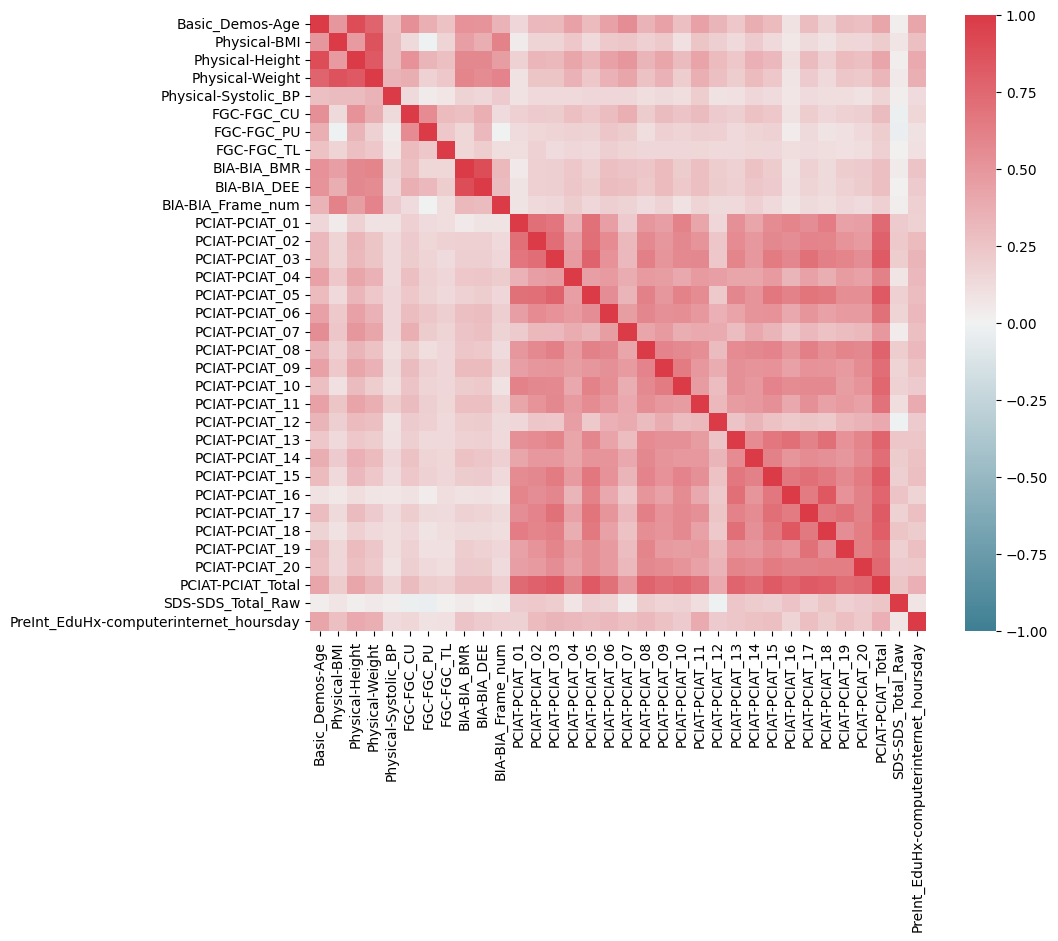

In [144]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = X_train_filtered.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

Posso allenare una random forest per eseguire un'ulteriore scrematura delle features.

C:\Users\Dav\AppData\Local\Temp\ipykernel_16032\2024584434.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance_cv_sorted, y=feat_importance_cv_sorted.index, palette="viridis")


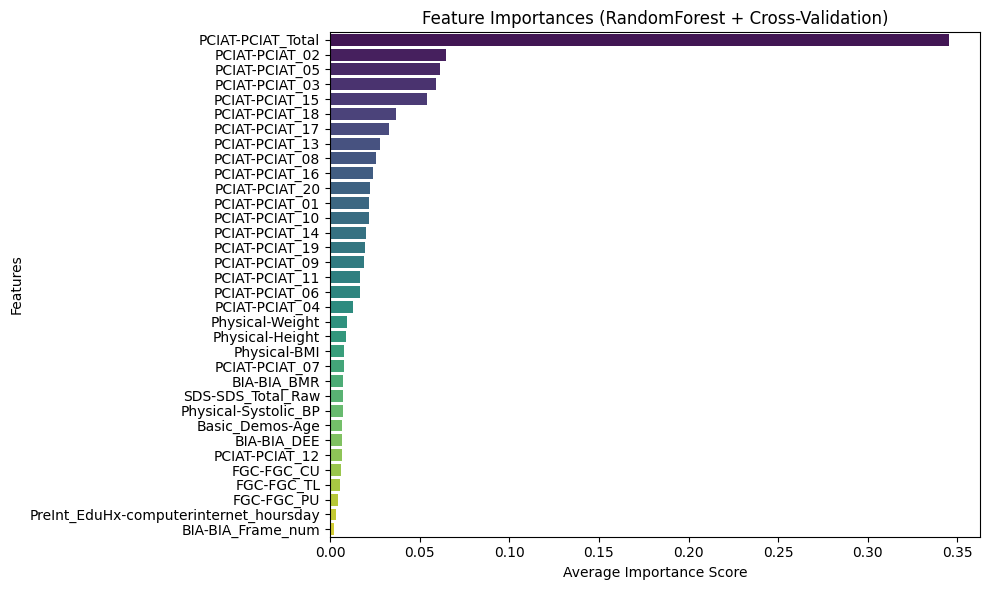

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
importances_list = []

for train_idx, val_idx in kf.split(X_train_filtered, y_train):
    X_fold_train, y_fold_train = X_train_filtered.iloc[train_idx], y_train.iloc[train_idx]
    
    model = RandomForestClassifier(random_state=SEED)
    model.fit(X_fold_train, y_fold_train)
    
    importances_list.append(model.feature_importances_)

# Media delle importanze sui fold
mean_importances = np.mean(importances_list, axis=0)

# Associa nomi feature
feat_importance_cv = pd.Series(mean_importances, index=X_train_filtered.columns)
feat_importance_cv_sorted = feat_importance_cv.sort_values(ascending=False)

# Visualizza
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance_cv_sorted, y=feat_importance_cv_sorted.index, palette="viridis")
plt.title("Feature Importances (RandomForest + Cross-Validation)")
plt.xlabel("Average Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


Dai grafici risultati si legge che la feature che contribuisce di più alla predizione di Sii è la variabile PCIAT-PCIAT_Total seguite dalle domande '02' , '05','03','15','17'.

Può essere interessante anche buttare un occhio all'analisi statistica "mutual information", che non dipende dal modello, ma misura "quanto sapere la feature aiuta a prevedere la classe". Messa in grafico col NaN ratio, dà anch'essa una buona misura di cosa sia significativo o meno, per confrontarlo coi risultati ottenuti dalla feature importance appena calcolata. 

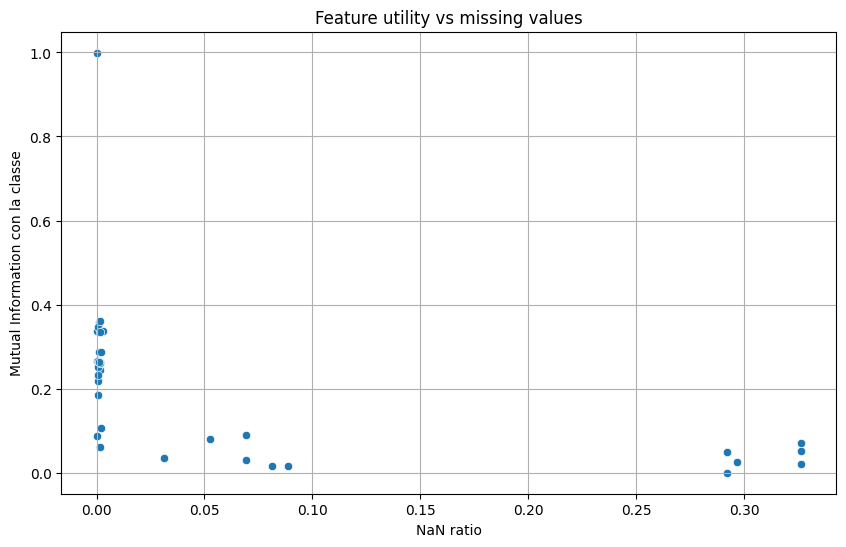

In [146]:
X_train_mi = X_train_filtered.copy()
Y_train_mi = y_train.copy() 

mi = mutual_info_classif(X_train_mi.fillna(-9999), Y_train_mi) # non gestisce in automatico i NaN

mi_series = pd.Series(mi, index=X_train_mi.columns)

nan_ratio = X_train_mi.isnull().mean()

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=nan_ratio, y=mi_series)
plt.xlabel("NaN ratio")
plt.ylabel("Mutual Information con la classe")
plt.title("Feature utility vs missing values")
plt.grid(True)
plt.show()

**Osservazioni:**

* Molti punti si trovano a sinistra (NaN ≈ 0), il che indica che molte feature non hanno praticamente valori mancanti.
* Alcune feature mostrano un valore di Mutual Information (MI) superiore a 0.2, segnalando una forte relazione con la label.
* Ci sono feature con il 30% di valori assenti e una MI bassa -> queste presumibilmente risultano poco informative.
* Viene confermata la presenza di almeno una feature con MI ≈ 1, fortemente predittiva della label.

Mutual Information e Feature Importance sono concetti simili, ma non equivalenti.

* La Mutual Information valuta la dipendenza tra una singola feature e la label, senza tenere conto di correlazioni tra le feature.
* La Feature Importance calcolata su un modello ad albero (nello specifico del nostro caso, Random Forest) misura quanto una feature contribuisce alla goodness durante le split, quindi nel contesto del modello.

Entrambi gli approcci presentano limiti, ma in modo opposto:

* Se due feature sono fortemente correlate tra loro, la Feature Importance può "dividersi" tra le due. Una potrebbe risultare poco importante semplicemente perché l'informazione è già stata assorbita dall'altra nei rami precedenti.
* La Mutual Information, invece, non tiene conto delle combinazioni tra feature. Una singola feature può avere MI ≈ 0, ma una combinazione di due feature può essere altamente predittiva. Un esempio è `Y = A XOR B`: A e B da sole non predicono Y, ma la loro combinazione sì. Scartandone una si perderebbe completamente la capacità predittiva.

Per questo motivo è utile valutare visivamente entrambe le misure nelle fasi preliminari, prima di prendere decisioni definitive sull'eliminazione delle feature.

In [147]:
nan_1 = mi_series[nan_ratio > 0.25]
print("Feature con NaN ratio > 0.25:")
print(nan_1)

mi_high_sorted = mi_series[mi_series > 0.2].sort_values(ascending=False)
print("\nFeature con alta mutual information, ordinate in modo decrescente:")
print(mi_high_sorted)

Feature con NaN ratio > 0.25:
FGC-FGC_CU           0.049564
FGC-FGC_PU           0.026399
FGC-FGC_TL           0.000000
BIA-BIA_BMR          0.051324
BIA-BIA_DEE          0.069532
BIA-BIA_Frame_num    0.019574
dtype: float64

Feature con alta mutual information, ordinate in modo decrescente:
PCIAT-PCIAT_Total    0.999244
PCIAT-PCIAT_15       0.360648
PCIAT-PCIAT_03       0.355543
PCIAT-PCIAT_05       0.345936
PCIAT-PCIAT_02       0.338038
PCIAT-PCIAT_17       0.336421
PCIAT-PCIAT_18       0.335950
PCIAT-PCIAT_08       0.288153
PCIAT-PCIAT_13       0.287535
PCIAT-PCIAT_10       0.266857
PCIAT-PCIAT_01       0.266380
PCIAT-PCIAT_16       0.263958
PCIAT-PCIAT_20       0.263954
PCIAT-PCIAT_19       0.260822
PCIAT-PCIAT_14       0.251247
PCIAT-PCIAT_09       0.244048
PCIAT-PCIAT_11       0.233497
PCIAT-PCIAT_06       0.219292
dtype: float64


Notiamo immediatamente che le features con 'mi' maggiore sono le stesse (anche se in un ordine leggermente diverso) delle feature che prima abbiamo visto essere più importanti. Ugualmente, come era facile immaginare, le feature con un NaN ratio abbastanza alto risultano anche tra le meno significative nel test della feature importance. Con questa conferma, è quindi possibile procedere all'eliminazione delle features meno importanti usando la random forest 

Ora, è chiaro che le varie 'PCIAT' sono feature che soffrono di **data leakage**. Cioè, sono informazioni quasi identiche al target, che probabilmente sono direttamente usate per definire il sii, o derivate da quest'ultimo in modo deterministico o quasi. 
Si rivela quindi necessario eliminare queste features, che oltretutto non saranno disponibili sui dati futuri. 

Essendo però estremamente significative per predire il sii, si possono usare per inferire un valore per l'sii quando quest'ultimo non è disponibile (è NaN), così da avere più dati su cui allenare il modello.

### Proxy Model
Procediamo quindi con la creazione del modello di imputazione. Dovremo quindi rifare i passaggi già eseguiti, in quanto il primo passo fatto è stato eliminare le righe con sii ignoto
1. a Partire dal dataset originale, ripetiamo i passi base di preparazione dati:
   1. separiamo train/test
   2. A partire da X_train creiamo due df distinti, di cui uno contiene le righe del training set dove sii è noto, uno dove è NaN
   3. uso le PCIAT come features e sii come target per allenare una semplice ma efficace random forest, che poi uso sul df con sii NaN.
2. A questo punto, imputiamo i valori di sii mancanti.
3. Ora posso droppare direttamente le colonne PCIAT, e ripetere la feature selection come fatta prima, senza che queste colonne siano coinvolte.

In [148]:
# read data : 
data = pd.read_csv("../data/train.csv") # dataset intero

Y = data['sii']     # classe da predire
X = data.drop(columns=['id','sii'])     # features

print("X shape", X.shape)

proxy_features = [
    'PCIAT-PCIAT_Total', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 
    'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05',
    'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 
    'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 
    'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 
    'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 
    'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-Season'
]

# Divisione train/test (80/20)
# Manteniamo X_test e y_test separati e non li tocchiamo più 
# fino alla valutazione finale
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)

# rieseguo il mapping stagioni sul nuovo dataset
season_cols = [col for col in X_train_full.columns if col.endswith('Season')]
for col in season_cols:
    X_train_full[col] = X_train_full[col].map(season_map)

# nel test devo eliminare i nan (non posso imputarli)
mask = ~y_test.isna()
y_test = y_test[mask]
X_test = X_test[mask]

# Creiamo un unico dataframe di training per manipolarlo più facilmente
train_df = pd.concat([X_train_full, y_train_full], axis=1)

# divisione del training set tra con_sii e senza_sii
train_con_sii = train_df[train_df['sii'].notnull()].copy()
train_da_imputare = train_df[train_df['sii'].isnull()].copy()

print(f"Righe di X_training con 'sii' noto: {len(train_con_sii)}")
print(f"Righe di X_training da imputare: {len(train_da_imputare)}")

# Prepariamo i dati per allenare il modello di imputazione
X_proxy_train = train_con_sii[proxy_features]
y_proxy_train = train_con_sii['sii']

# alleniamo quindi una rf per imputazione
proxy_model = RandomForestClassifier(random_state=SEED)
proxy_model.fit(X_proxy_train, y_proxy_train)

# Prepariamo le feature delle righe da imputare
X_proxy_predict = train_da_imputare[proxy_features]

# Usiamo il modello per predire i valori di 'sii' mancanti
sii_imputati = proxy_model.predict(X_proxy_predict)

# Assegniamo i valori predetti alla colonna 'sii' del set da imputare
train_da_imputare['sii'] = sii_imputati

# Uniamo i due set
train_df_augmented = pd.concat([train_con_sii, train_da_imputare])

# Ora possiamo separare di nuovo le feature e la label (X e Y)
y_train_final = train_df_augmented['sii']
X_train_final = train_df_augmented.drop(columns=['sii'])

# a questo punto abbiamo un training set completo con 'sii' noto per tutte le righe
# Possiamo quindi eliminare le feature usate per l'imputazione, così da non influenzare il modello finale
# con feature che soffrono di data leakage
X_train_final = X_train_final.drop(columns=proxy_features)

print(f"Dimensioni di X_train_final: {X_train_final.shape}")
print(f"Dimensioni di y_train_final: {y_train_final.shape}")
print(f"Dimensioni di X_test: {X_test.shape}")

X shape (3960, 80)
Righe di X_training con 'sii' noto: 2193
Righe di X_training da imputare: 975
Dimensioni di X_train_final: (3168, 58)
Dimensioni di y_train_final: (3168,)
Dimensioni di X_test: (543, 80)


A questo punto, abbiamo quasi 1000 righe in più su cui allenare i modelli.
* `X_train_final`: contiene il set di training, totale: senza le colonne PCIAT e aumentato con le righe che inizialmente avevano sii nullo
* `y_train_final`: target del training, con tutte le righe
* `X_test`, `y_test`: set di test, intoccati

Possiamo quindi procedere a rifare i passi eseguiti in precedenza riguardanti pulizia dei dati e feature importance. (cambiare le stagioni, matrice di correlazione, feature importance, nan ratio)

<Axes: >

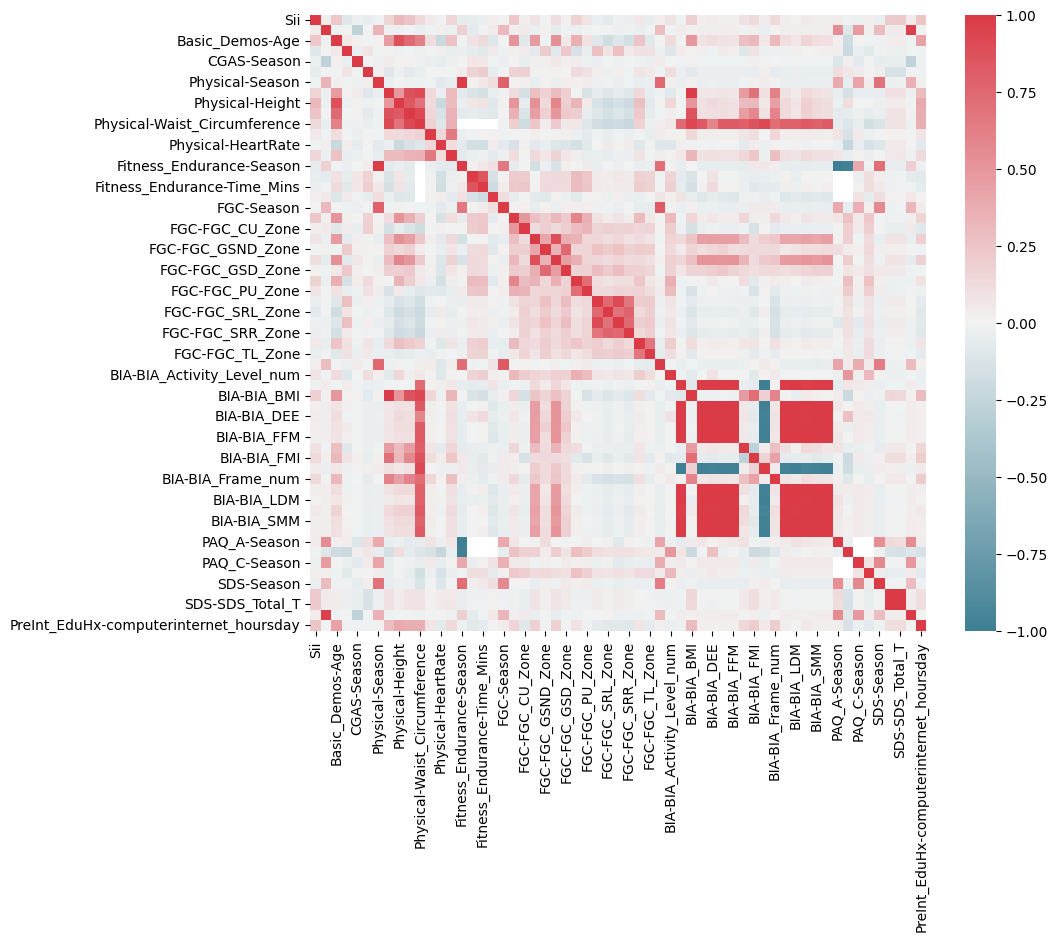

In [149]:
# Calcolo matrice di correlazione (con il target)
X_temp = X_train_final.copy()
X_temp.insert(0, column="Sii", value=y_train_final)

f, ax = plt.subplots(figsize=(10, 8))
corr = X_temp.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

C:\Users\Dav\AppData\Local\Temp\ipykernel_16032\3080398676.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance_cv_sorted, y=feat_importance_cv_sorted.index, palette="viridis")


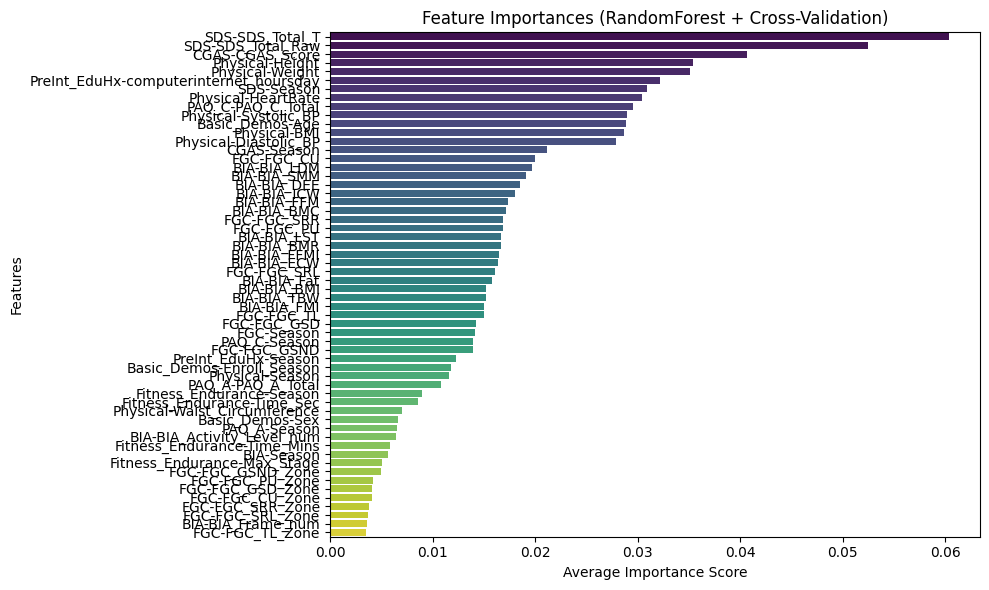

In [150]:
# cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
importances_list = []

for train_idx, val_idx in kf.split(X_train_final, y_train_final):
    X_fold_train, y_fold_train = X_train_final.iloc[train_idx], y_train_final.iloc[train_idx]
    
    model = RandomForestClassifier(random_state=SEED)
    model.fit(X_fold_train, y_fold_train)
    
    importances_list.append(model.feature_importances_)

# Media delle importanze sui fold
mean_importances = np.mean(importances_list, axis=0)

# Associa nomi feature
feat_importance_cv = pd.Series(mean_importances, index=X_train_final.columns)
feat_importance_cv_sorted = feat_importance_cv.sort_values(ascending=False)

# Visualizza
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance_cv_sorted, y=feat_importance_cv_sorted.index, palette="viridis")
plt.title("Feature Importances (RandomForest + Cross-Validation)")
plt.xlabel("Average Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Si nota immediatamente quanto questo grafico sia diverso da quello visto in precedenza: l'importance score è in generale molto più basso e decisamente meno sbilanciato di prima.

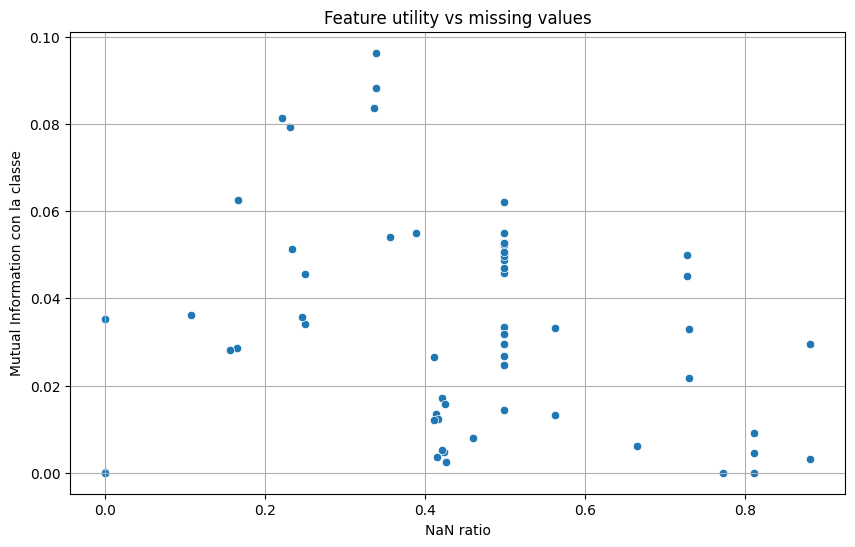

In [151]:
X_train_mi = X_train_final.copy()
Y_train_mi = y_train_final.copy() 

mi = mutual_info_classif(X_train_mi.fillna(-9999), Y_train_mi) # non gestisce in automatico i NaN

mi_series = pd.Series(mi, index=X_train_mi.columns)

nan_ratio = X_train_mi.isnull().mean()

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=nan_ratio, y=mi_series)
plt.xlabel("NaN ratio")
plt.ylabel("Mutual Information con la classe")
plt.title("Feature utility vs missing values")
plt.grid(True)
plt.show()

Vediamo che ci sono alcune features con NaN ratio molto alto, che sono poco significative. Ci sono poi alcune features che hanno una MI con la label quasi nulla. Controlliamo quali sono:

In [152]:
# creo un dataframe temporaneo per visualizzare le feature con NaN ratio > 0.8 e la loro mutual information
nan_1_df = pd.DataFrame({
    'NaN ratio': nan_ratio[nan_ratio > 0.8],
    'Mutual Info': mi_series[nan_ratio > 0.8]
}).sort_values(by='NaN ratio', ascending=False)

print("Feature con NaN ratio > 0.8:")
print(nan_1_df)

mi_high_sorted = mi_series[mi_series > 0.06].sort_values(ascending=False)
print("\nFeature con alta mutual information, ordinate in modo decrescente:")
print(mi_high_sorted)

Feature con NaN ratio > 0.8:
                             NaN ratio  Mutual Info
PAQ_A-PAQ_A_Total             0.881313     0.003113
PAQ_A-Season                  0.881313     0.029499
Fitness_Endurance-Time_Sec    0.811869     0.004490
Fitness_Endurance-Time_Mins   0.811869     0.000000
Fitness_Endurance-Max_Stage   0.810922     0.009008

Feature con alta mutual information, ordinate in modo decrescente:
SDS-SDS_Total_Raw                         0.096325
SDS-SDS_Total_T                           0.088305
SDS-Season                                0.083541
Physical-Weight                           0.081362
Physical-Height                           0.079359
PreInt_EduHx-computerinternet_hoursday    0.062661
BIA-BIA_LDM                               0.062018
dtype: float64


Le features con NaN ratio alto non sono in assoluto quelle con importance minore, ma sono comunque nella bassa classifica, come atteso. Ugualmente alta mutual information corrisponde ad alta importance.
Data questa conferma, possiamo proseguire con l'eliminazione delle features meno significative



### Feature subset selection by elimination

Dopo aver ottenuto le importanze delle feature via Random Forest con cross-validation e aver avuto conferma dei dati anche con un secondo metodo, possiamo procedere con una selezione backward. L’idea è semplice: partiamo dal set completo di feature e rimuoviamo iterativamente quella meno importante (in base alla feature importance). A ogni rimozione, valutiamo le performance del modello su un set di validazione.

Questo approccio ha un vantaggio interessante: quando due feature sono molto correlate, la Random Forest tende a "dividersi" l’importanza tra le due, facendo sembrare ognuna meno utile individualmente. Con la backward elimination, però, appena una delle due viene rimossa, l’importanza dell’altra può impennarsi e rivelarsi cruciale. In pratica: il metodo compensa la penalizzazione delle feature ridondanti.

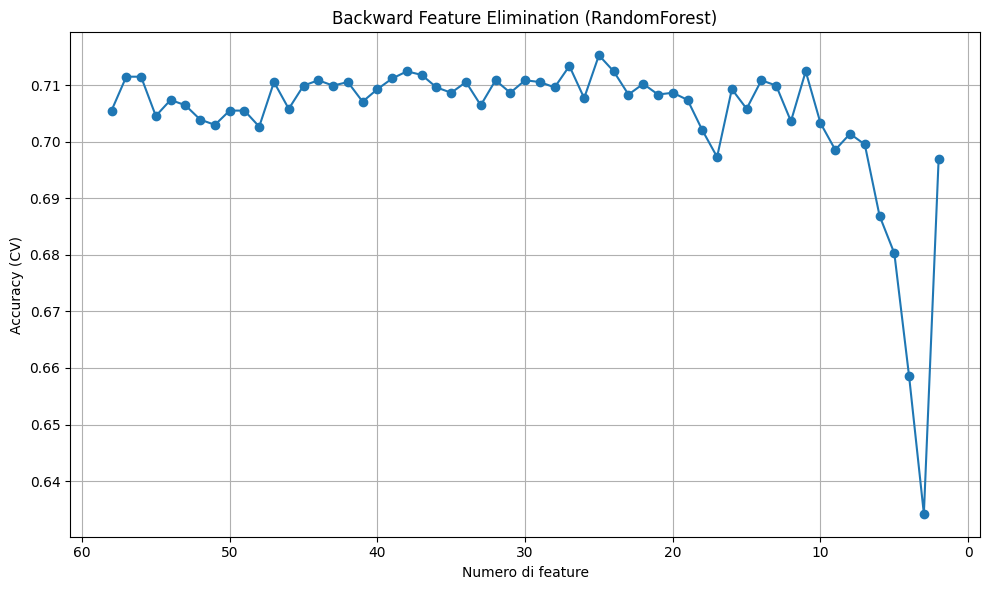

In [153]:
from sklearn import clone
from sklearn.model_selection import cross_val_score


X_be = X_train_final.copy()
y_be = y_train_final.copy()
features = list(feat_importance_cv_sorted.index)

# Setup modello base
base_model = RandomForestClassifier(random_state=SEED)

# Per salvare l’andamento delle performance
scores = []
n_features = []

# Loop backward
while len(features) > 1:
    # Modello con feature correnti
    X_current = X_be[features]
    
    score = cross_val_score(clone(base_model), X_current, y_be, cv=5, scoring='accuracy').mean()
    scores.append(score)
    n_features.append(len(features))
    
    # Rimuovi la feature meno importante tra quelle rimaste
    feat_importance_sub = feat_importance_cv[features]
    worst_feature = feat_importance_sub.idxmin()
    features.remove(worst_feature)

# Visualizzazione andamento performance
plt.figure(figsize=(10, 6))
plt.plot(n_features, scores, marker='o')
plt.xlabel("Numero di feature")
plt.ylabel("Accuracy (CV)")
plt.title("Backward Feature Elimination (RandomForest)")
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


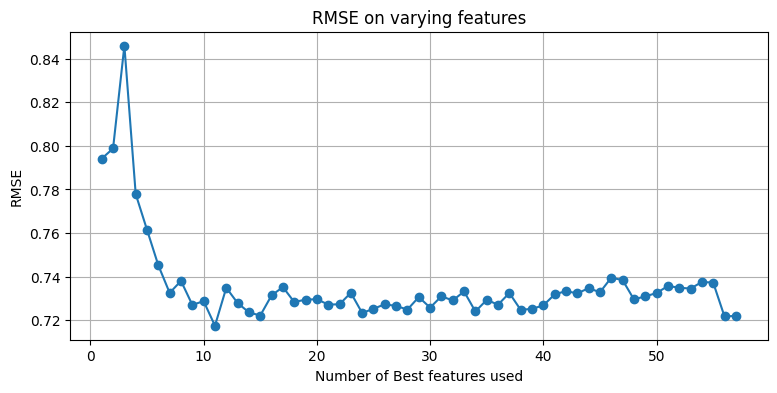

In [154]:
rmse = []
for f in range (1, len(feat_importance_cv_sorted)):
    rf_small = RandomForestClassifier(random_state=SEED)
    scores = cross_val_score(
        rf_small, 
        X_train_final[feat_importance_cv_sorted.index[:f]],
        y_train_final,
        cv=5,
        scoring='neg_root_mean_squared_error'  # Usando RMSE come metrica
    )
    rmse.append(-scores.mean())  # Negativo perché cross_val_score restituisce valori negativi per le metriche di errore

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(range(1,len(feat_importance_cv_sorted)), rmse, 'o-', label="RMSE")
ax.set_title("RMSE on varying features")
ax.set_xlabel("Number of Best features used")
ax.set_ylabel("RMSE")
ax.grid();

Da questi due grafici si evince che è possibile eliminare ripetutamente le features senza perdite in termini di accuracy: è chiaro come avere una decina di features sia tanto significativo quanto averle tutte, la perdita di accuracy è totalmente giustificata dalla semplificazione del modello. nel range 20-10 c'è una diminuzione leggermente più marcata, con maggiore varibilità, ma forse ugualmente accettabile. Da 11 in giù le performance calano sensibilmente. Abbiamo scelto di tenerne quindi 11. proseguiamo quindi con:
1. Mostrare le feature ordinate per importanza
2. Selezionare le prime 11 e droppare dal dataset le features non utilizzate

In [155]:
# Mostra le prime 11 feature
top11_features = feat_importance_cv_sorted.index[:11].tolist()
print("Top 11 features (RandomForest CV):")
for i, f in enumerate(top11_features, 1):
    print(f"{i}. {f}")

# droppa le altre
X_train_final = X_train_final[top11_features].copy()

Top 11 features (RandomForest CV):
1. SDS-SDS_Total_T
2. SDS-SDS_Total_Raw
3. CGAS-CGAS_Score
4. Physical-Height
5. Physical-Weight
6. PreInt_EduHx-computerinternet_hoursday
7. SDS-Season
8. Physical-HeartRate
9. PAQ_C-PAQ_C_Total
10. Physical-Systolic_BP
11. Basic_Demos-Age


# Modello Base per il confronto con gli altri modelli.
Uno dei modelli più semplici che si possono utilizzare per eseguire delle predizioni è la moda.

In [156]:
from sklearn.metrics import accuracy_score


y_train_mode = y_train_final.mode()[0]

# Predizione costante sul test
y_pred_base = [y_train_mode] * len(y_test)

# Accuracy baseline
base_accuracy = accuracy_score(y_test, y_pred_base)
print("Baseline accuracy:", base_accuracy)


Baseline accuracy: 0.572744014732965


Posso usare una confusion matrix per avere un modello base per fare un benchmark di partenza

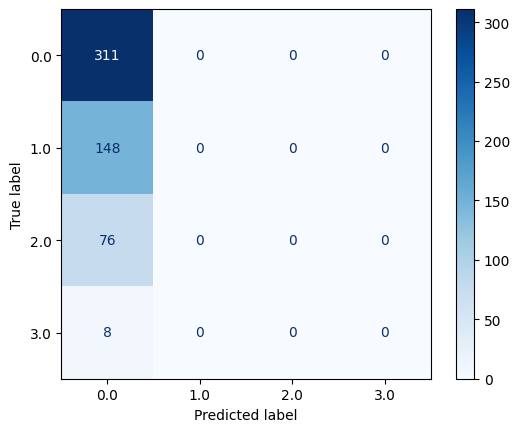

In [157]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y_test)))
disp.plot(cmap=plt.cm.Blues)
plt.show()


Si può notare che utilizzando la statistica della moda,il nostro modello ottiene il 57% delle predizioni corrette.
Il nostro obbiettivo è quindi di trovare quei modelli che permettano di migliorare le predizioni in particolare per quei valori di Sii come 3.0 la cui distribuzione è significativamente minore rispetto alle altre.

# MODELLO 2: RETE NEURALE CON KERAS
Ovvio che in generale vogliamo avere un'accuracy molto alta. Le classi però sono fortemente sbilanciate e, essendo un test medico, è essenziale minimizzare il numero di falsi negativi della categoria 3 (corrispondente a "severe"). Infatti, un falso positivo è meno problematico, in quanto dopo la predizione con il modello, si può eseguire un test reale sulla persona. In caso di un falso negativo, invece, si scarta a priori l'ipotesi ed è più improbabile che venga effettuato un ulteriore test. 

### Dati
I dati che useremo sono quelli creati nella prima sezione del documento.
* `X_train_final` e `y_train_final`: rispettivamente sono le features e la label dei dati di train, aumentati di circa 1000 righe con l'imputazione dell'sii mancante.
* `X_test` e `y_test`: come sopra, per il test. Non hanno righe NaN.



In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, recall_score

tf.random.set_seed(SEED)

### label encoding
Keras per classificazione multi-classe con loss `sparse_categorical_crossentropy`, richiede che queste classi siano codificate come interi da 0 a `n - 1` senza salti, quindi dobbiamo convertire gli attuali valori, float64, in int

In [180]:
y_train_final = y_train_final.astype(int)
y_test = y_test.astype(int)

Il test **non verrà mai usato** se non alla fine, per valutare le performance del modello. La calibrazione degli iperparametri verrà quindi eseguita usando un *validation set*, in particolare di tipo *stratified*, così da avere la stessa proporzione delle classi tra train e validation, fondamentale nel caso di dati sbilanciati come i nostri.

avendo un dataset abbastanza grande, ma pochissimi esempi della classe 3, non posso prendere un validation troppo piccolo. divido 60% training e 40% validation

Quantità di esempi per ogni classe nel training set:
sii
0    1354
1     349
2     181
3      16
Name: count, dtype: int64
Quantità di esempi per ogni classe nel validation set:
sii
0    904
1    233
2    121
3     10
Name: count, dtype: int64


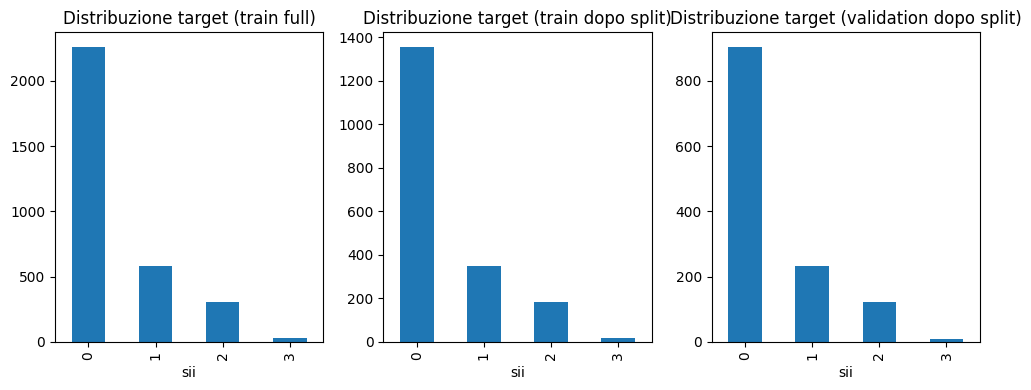

In [201]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_final, y_train_final,
    test_size=0.40,
    stratify=y_train_final,
    random_state=SEED
)

# X_tr.shape 1900 righe, 11 colonne
# X_val.shape 1268 righe, 11 colonne

# conto quantità di esempi per ogni classe del trining
class_counts = y_tr.value_counts().sort_index()
print("Quantità di esempi per ogni classe nel training set:")
print(class_counts)
# conto quantità di esempi per ogni classe della validation
class_counts_val = y_val.value_counts().sort_index()
print("Quantità di esempi per ogni classe nel validation set:")
print(class_counts_val)

# purtroppo, pochissimi esempi della classe 3

# controllo visivo sulla distribuzione delle classi
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
y_train_final.value_counts().sort_index().plot(kind='bar', title='Distribuzione target (train full)')
plt.subplot(1,3,2)
y_tr.value_counts().sort_index().plot(kind='bar', title='Distribuzione target (train dopo split)')
plt.subplot(1,3,3) 
y_val.value_counts().sort_index().plot(kind='bar', title='Distribuzione target (validation dopo split)')
plt.tight_layout() # per evitare sovrapposizioni
plt.show()


### Normalizzazione dei dati di training (features) con StandardScaler di scikit-learn.
standardizza le feature rimuovendo la media e scalando alla varianza unitaria:
$ z = \frac{x - \mu}{\sigma} $.
Per ora, tutti i NaN li imposto a -9999. valore che ovviamente non c'entra nulla con i dati. Dopodiché vedremo se necessario di imputarli in qualche modo.

In [202]:
scaler = StandardScaler()

# uso il train per calcolare media e deviazione standard, e standardizzo tutto (train, val, test)

X_tr_filled = X_tr.fillna(-9999).copy() 
X_val_filled = X_val.fillna(-9999).copy()  

X_tr_scaled = scaler.fit_transform(X_tr_filled)    
X_val_scaled = scaler.transform(X_val_filled)

### Assegnazione pesi alle labels
Essendo un dataset sbilanciato, è necessario dare un peso ad ogni classe, altrimenti il modello ricalcherà molto bene solo la classe più frequente. Assegno quindi dei pesi in automatico (balanced significa proporzionale) alle varie classi.
Come detto in precedenza, ciò a cui puntiamo è la massimizzazione della recall sulla classe 3. Ciò significa che, probabilmente, dopo il peso di quest'ultima dovà essere arbitrariamente aumentato, perché il modello riesca a prendere più informazione specifica

I pesi vengono applicati direttamente alla loss per ogni esempio. Servono per dire al modello: “Se sbagli questa classe, è molto più grave”.

In [204]:
classes = np.unique(y_tr) # array delle classi presenti nel training set
num_classes = len(classes)

auto_weights = compute_class_weight(class_weight='balanced',
                                    classes=classes,
                                    y=y_tr)
class_weights = {cls: w for cls, w in zip(classes, auto_weights)}

print("Class weights:", class_weights)

Class weights: {np.int64(0): np.float64(0.35081240768094535), np.int64(1): np.float64(1.3610315186246418), np.int64(2): np.float64(2.6243093922651934), np.int64(3): np.float64(29.6875)}


### Costruzione del modello neurale (`build_model`)

In questa funzione definiamo in modo flessibile l’architettura della rete neurale feed-forward da utilizzare per la classificazione.  
L’input è costituito da `n_features` (pari al numero di variabili predittive dopo la pulizia e la selezione), mentre l’output ha `n_classes` neuroni, uno per ciascuna classe di severità.

L’architettura è personalizzabile passando:
- **`hidden_units`**: lista con il numero di neuroni in ciascun layer nascosto (default `[64, 32]`).
- **`activation`**: funzione di attivazione per i layer nascosti (default `ReLU`).
- **`dropout`**: percentuale di neuroni disattivati casualmente durante il training per ridurre l’overfitting.
- **`l2_reg`**: parametro di regolarizzazione L2 per penalizzare pesi troppo grandi. smorza un po' l'effetto dei pesi per evitare l'overfitting. Inizialmente viene impostato a 0 -> nessuna regolarizzazione
- **`lr`**: learning rate dell’ottimizzatore Adam.

La funzione crea i layer nascosti in un ciclo, applica eventuale dropout, e definisce il layer di output:
- **Softmax + `sparse_categorical_crossentropy`** per il caso multiclasse (più di due classi).
- **Sigmoid + `binary_crossentropy`** per il caso binario.

In [205]:
def build_model(n_features,
                n_classes,
                hidden_units=[64,32],
                activation='relu',
                lr=1e-3,
                dropout=0.0,
                l2_reg=0.0):
    
    # Definisce il layer di input, dimensione = numero di feature
    inputs = layers.Input(shape=(n_features,))
    
    x = inputs    # Variabile temporanea per "costruire" i layer successivi
    for units in hidden_units:
        
        x = layers.Dense(units, # denso -> fully-connected
                         activation = activation,
                         kernel_regularizer = keras.regularizers.l2(l2_reg))(x) # l2_reg
        if dropout and dropout > 0.0: 
            x = layers.Dropout(dropout)(x) # applico il dropout
    
    if n_classes == 2: # classificazione binaria
        out = layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
   
    else: # classificazione multiclasse
        out = layers.Dense(n_classes, activation='softmax')(x)
        loss = 'sparse_categorical_crossentropy'

    model = keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

### Baseline "evoluta": rete neurale semplice

Addestriamo una prima versione della rete neurale costruita in precedenza (`build_model`) per stabilire un punto di riferimento con cui confrontare le successive prove. Ovviamente ci si aspetta che l'accuracy sia migliore della baseline trovata con la moda. Notare però che in questo caso non possiamo usare i dati di test, perché faremmo tuning dei parametri su quelli, dobbiamo invece usare il validation.

- **EarlyStopping**: interrompiammo il training se la loss di validazione non migliora per un certo numero di epoche, evitando overfitting.
- **ReduceLROnPlateau** per ridurre il learning rate se la loss di validazione si stabilizza, migliorando la convergenza.
Il training è ponderato con `class_weight` per dare più importanza alle classi meno rappresentate, in particolare la classe 3.

In [206]:
# -----------------------------------------------
# Costruisco la funzione per eseguire il modello
# -----------------------------------------------


""""
hidden_units: lista di interi, numero di neuroni per layer nascosti
activation: stringa, funzione di attivazione da usare nei layer nascosti
lr: float, learning rate iniziale
dropout: float, percentuale di dropout da applicare
l2_reg: float, coefficiente di regolarizzazione L2
patience_early_stopping: int, numero di epoche senza miglioramento prima di fermare l'allenamento
patience_reduce_lr: int, numero di epoche senza miglioramento prima di ridurre il learning rate
factor: float, fattore di riduzione del learning rate se la loss di validazione non migliora
min_lr: float, learning rate minimo a cui ridurre
epochs: int, numero massimo di epoche per l'allenamento
batch_size: int, numero di campioni per batch
"""
def esegui_modello (hidden_units=[64,32], activation='relu', lr=1e-4, dropout=0, l2_reg=0, patience_early_stopping = 50, patience_reduce_lr = 6, factor = 0.5, min_lr=1e-6, epochs = 500, batch_size=32):
    # ----------------------
    # modellazione effettiva
    # ----------------------
    model = build_model(
        n_features=n_features,          # input
        n_classes=num_classes,          # output
        hidden_units=hidden_units,      # due con 64 e 32 neuroni
        activation=activation,          # f di attivazione
        lr=lr,                          # learning rate iniziale
        dropout=dropout,                # dropout inizialmente 0
        l2_reg=l2_reg                   # regolarizzazione L2 idem
    )

    callbacks = [
        # early stop se la loss di validazione non migliora per tot epoche consecutive
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_early_stopping, restore_best_weights=True),

        # Se la loss di validazione non migliora per tot epoche, riduce il learning rate del factor%
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience_reduce_lr, min_lr=min_lr)
    ]

    history = model.fit(
        X_tr_scaled,
        y_tr,
        validation_data=(X_val_scaled, y_val),
        epochs=epochs, 
        batch_size=batch_size, # numero di campioni per batch
        class_weight=class_weights, # pesi classi
        callbacks=callbacks, 
        verbose=1
    )


    # ----------------------
    # risultati
    # ----------------------

    print("training terminato")

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')      # andamento loss sul training
    plt.plot(history.history['val_loss'], label='val loss')    # andamento loss su validation
    plt.title('Loss per epoca')                                
    plt.legend()                                               

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train acc')   # andamento accuracy sul training
    plt.plot(history.history['val_accuracy'], label='val acc') # andamento accuracy su validation
    plt.title('Accuracy per epoca')                            
    plt.legend()                                               

    plt.show()

    # Predizioni di probabilità sul validation set
    y_val_pred_proba = model.predict(X_val_scaled)

    # Conversione da probabilità a classe predetta
    if num_classes == 2:
        # Caso binario: threshold 0.5
        y_val_pred = (y_val_pred_proba.ravel() >= 0.5).astype(int)
    else:
        # Caso multiclasse: argmax
        y_val_pred = np.argmax(y_val_pred_proba, axis=1)

    # --- Report di classificazione ---
    print("Classification report (validation):")
    print(classification_report(y_val, y_val_pred, digits=4))

    # --- Confusion matrix ---
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')        # asse X: predizioni
    plt.ylabel('True')             # asse Y: valori reali
    plt.title('Confusion Matrix (validation)')
    plt.show()

    # --- Recall specifico per classe 3 ---
    rec_severe = recall_score(y_val, y_val_pred, labels=[3], average='macro')
    print(f"Recall classe severe (3): {rec_severe:.4f}")

    # --- Precision-Recall curve per classe 3 ---
    y_true_bin = (y_val == 3).astype(int)
    y_scores_severe = y_val_pred_proba[:, 3]
    prec, rec, thresh = precision_recall_curve(y_true_bin, y_scores_severe)
    ap = average_precision_score(y_true_bin, y_scores_severe)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=f'PR curve (severe), AP={ap:.3f}')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision-Recall (classe severe)')
    plt.legend(); plt.grid(); plt.show()


### Visualizzazione dell’andamento del training

Tracciamo i grafici dell’andamento di **loss** e **accuracy** durante il training e la validazione.  
Questi grafici sono utili per:
- individuare il momento in cui il modello smette di migliorare (*early stopping point*);
- verificare se c’è overfitting (gap crescente tra train e validation);
- valutare la stabilità della curva di apprendimento.

### Valutazione del modello sul set di validazione

Eseguiamo poi la predizione sul set di validazione e calcoliamo le metriche di valutazione:
- **Classification report**: precision, recall e f1-score per ciascuna classe.
- **Confusion matrix**: visualizzazione degli errori e delle corrette classificazioni.
- **Recall della classe 3 ("severe")**: metrica prioritaria in questo progetto.

## Esecuzione modello semplice


Numero di feature: 11
Numero di classi: 4
NaN in X_tr_scaled: False
Inf in X_tr_scaled: False
NaN in X_val_scaled: False
Inf in X_val_scaled: False
Classi uniche in y_tr: [0 1 2 3]
Epoch 1/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5537 - loss: 1.3489 - val_accuracy: 0.5781 - val_loss: 1.2016 - learning_rate: 1.0000e-04
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5763 - loss: 1.3109 - val_accuracy: 0.5828 - val_loss: 1.1621 - learning_rate: 1.0000e-04
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5795 - loss: 1.2820 - val_accuracy: 0.5804 - val_loss: 1.1326 - learning_rate: 1.0000e-04
Epoch 4/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5779 - loss: 1.2578 - val_accuracy: 0.5718 - val_loss: 1.1100 - learning_rate: 1.0000e-04
Epoch 5/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5826 - loss: 1.2363 - val_accuracy: 0.5694 - val_loss: 1.0918 - learning_rate: 1.0000e-04
Epoch 6/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 

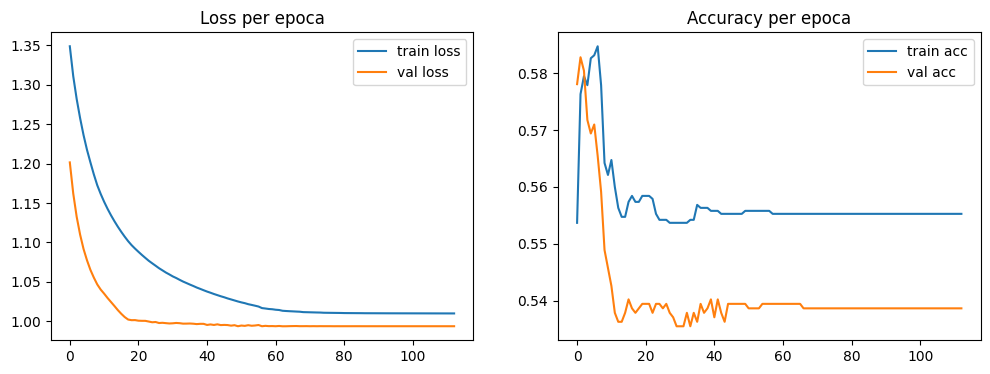

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Classification report (validation):
              precision    recall  f1-score   support

           0     0.9098    0.6250    0.7410       904
           1     0.2691    0.4077    0.3242       233
           2     0.2073    0.1405    0.1675       121
           3     0.0330    0.7000    0.0631        10

    accuracy                         0.5394      1268
   macro avg     0.3548    0.4683    0.3239      1268
weighted avg     0.7181    0.5394    0.6043      1268



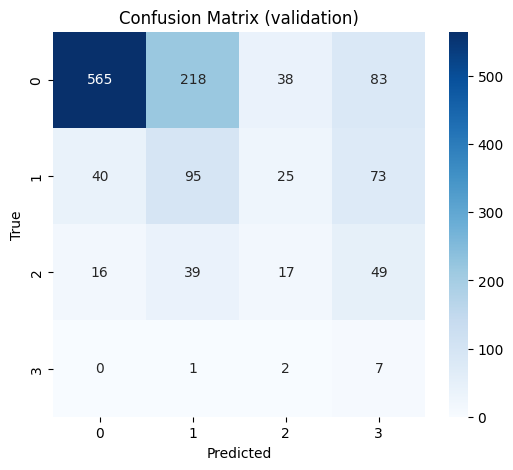

Recall classe severe (3): 0.7000


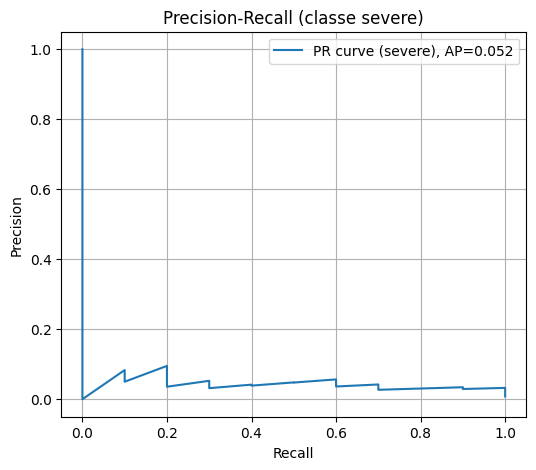

In [207]:
n_features = X_tr_scaled.shape[1]
print("Numero di feature:", n_features)
print("Numero di classi:", num_classes)
print("NaN in X_tr_scaled:", np.isnan(X_tr_scaled).any())
print("Inf in X_tr_scaled:", np.isinf(X_tr_scaled).any())
print("NaN in X_val_scaled:", np.isnan(X_val_scaled).any())
print("Inf in X_val_scaled:", np.isinf(X_val_scaled).any())
print("Classi uniche in y_tr:", np.unique(y_tr))

# eseguiamo il modello con i parametri di default
esegui_modello()

## considerazioni sul modello

### metriche di valutazione

Ricordiamo cosa sono le varie metriche utilizzate: 

* **Accuracy**: $ = \frac{TP + TN}{TP + TN + FP + FN} $. Percentuale di predizioni corrette sul totale. Con dataset sbilanciati può essere fuorviante: basta indovinare sempre la classe più frequente per avere un valore alto
* **Precision** $ = \frac{TP}{TP + FP} $. Quanti tra i predetti positivi sono davvero positivi. Alta precisione significa pochi falsi positivi.  
* **Recall** $ = \frac{TP}{TP + FN} $ Quanti tra i positivi reali sono stati riconosciuti. Alta recall significa pochi falsi negativi.  

Se ci limitassimo a massimizzare solo la recall, basterebbe predire sempre “positivo”: in questo modo i falsi negativi sarebbero zero e la recall diventerebbe 1. Allo stesso modo, se cercassimo solo la massima precisione, potremmo predire “positivo” solo in casi rarissimi, riducendo i falsi positivi a zero. Entrambe le metriche, quindi, da sole sono inutili, serve un bilanciamento.

* **F1-score**  $ = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $. È la media armonica tra precision e recall. Fornisce un compromesso tra i due valori e penalizza gli squilibri estremi. Utile soprattutto con dataset sbilanciati come il nostro.
* **Macro average e Weighted average**:
  - *Macro avg*: media aritmetica delle metriche per ogni classe, tratta tutte le classi in modo uguale. Evidenzia i problemi sulle classi piccole.  
  - *Weighted avg*: media pesata sul supporto. Un po' "pericolosa", può risultare alta anche se il modello fallisce completamente sulle classi piccole.

Il **supporto** non è una metrica, è il numero di esempi presenti in ogni classe nel set di valutazione. Notare che la classe 3 del validation ha solo 3 elementi.

### interpretazioni

Dai grafici si vede che la rete si è praticamente piantata:  
- la *val loss* resta attorno a 1 dopo poche epoche e non scende più,  
- l’accuracy si blocca intorno al 53-55% sia su train che su validation,  
- il learning rate è stato ridotto fino al minimo senza sbloccare la situazione.  

In particolare:
- la classe 0 ha precisione molto alta (0.91) ma recall 0.63, quindi molti esempi finiscono confusi altrove, essendo la classe maggioritaria non c'è da stupirsi che comunque abbia delle metriche buone.
- la classe 1 viene riconosciuta a tratti (recall ~0.4) ma con precisione molto bassa 
- la classe 2 quasi sempre persa (recall 0.14, F1 0.17)
- la classe 3 (severe, quella più critica) ha recall 0.7 ma precisione ridicola, significa che la rete la assegna a casi sbagliati (infatti vediamo 156 elementi "true 0" o "true 1" classificati come 3)
Il risultato complessivo è che l’accuracy globale e dominata dala classe 0, mentre macro-F1 è pessima (< 0.32), Si può quindi affermare che il modello non ha imparato nulla. 

### possibili passi futuri

- aumentare i pesi delle classi più rare (2 e soprattutto 3), così che incidano molto di più nella funzione di loss;  
- provare ad aumentare la capacità del modello (più neuroni e/o layer in più) e inserire un po’ di regolarizzazione (dropout o L2);  
- bilanciare meglio il dataset tramite oversampling/duplicazione delle classi 2 e 3, per permettere alla rete di vederle più spesso;
- imputare i valori inizialmente NaN, che adesso hanno un valore simbolico -9999

possiamo riutilizzare la funzione, cambiandone i parametri


### Tuning dei parametri e augmentation dei dati
La prima cosa che faccio è sistemare i valori NaN. Infatti, sostituirli con un placeholder come -9999 è solo un “trucco” per far girare il modello, ma non aggiunge nessuna informazione utile e anzi rischia di introdurre rumore. Un modo banale sarebbe utilizzare uno tra media, moda o mediana, ma c'è il rischio di inserire dati che oggettivamente non c'entrano nulla, finendo per far imparare pattern sbagliati al modello. Proseguo quindi utilizzando la distanza basata sulla Random Forest, che tenendo conto della relazione tra variabili permette di assegnare valori più probabilmente giusti. Magari sbagliati, ma sicuramente migliori delle altre metriche. Ovviamente come sempre i dati di test non vanno toccati. Rieseguito il modello senza toccarne i parametri, ottengo questi risultati:

In [208]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Imputazione dei valori mancanti
# Usando IterativeImputer con RandomForestRegressor come estimatore
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=50, random_state=SEED),
    max_iter=10,
    random_state=SEED
)

X_tr_imputed = imputer.fit_transform(X_tr) # li chiamo allo stesso modo di prima così da non dover cambiare il resto del codice
X_val_imputed = imputer.transform(X_val)

# eseguo quindi la standardizzazione
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

n_features = X_tr_scaled.shape[1]
print("Numero di feature:", n_features)
print("Numero di classi:", num_classes)
print("NaN in X_tr_scaled:", np.isnan(X_tr_scaled).any())
print("Inf in X_tr_scaled:", np.isinf(X_tr_scaled).any())
print("NaN in X_val_scaled:", np.isnan(X_val_scaled).any())
print("Inf in X_val_scaled:", np.isinf(X_val_scaled).any())
print("Classi uniche in y_tr:", np.unique(y_tr))


C:\Users\Dav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Numero di feature: 11
Numero di classi: 4
NaN in X_tr_scaled: False
Inf in X_tr_scaled: False
NaN in X_val_scaled: False
Inf in X_val_scaled: False
Classi uniche in y_tr: [0 1 2 3]


Epoch 1/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2389 - loss: 1.3951 - val_accuracy: 0.3028 - val_loss: 1.3251 - learning_rate: 1.0000e-04
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3405 - loss: 1.3569 - val_accuracy: 0.3983 - val_loss: 1.2931 - learning_rate: 1.0000e-04
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4174 - loss: 1.3223 - val_accuracy: 0.4377 - val_loss: 1.2633 - learning_rate: 1.0000e-04
Epoch 4/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4632 - loss: 1.2917 - val_accuracy: 0.4708 - val_loss: 1.2370 - learning_rate: 1.0000e-04
Epoch 5/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4895 - loss: 1.2639 - val_accuracy: 0.4874 - val_loss: 1.2140 - learning_rate: 1.0000e-04
Epoch 6/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4974 - loss: 1.2401 - val_accuracy: 0.4826 - val_loss: 1.1963 - learning_rate: 1.0000e-04
Epoch 7/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0

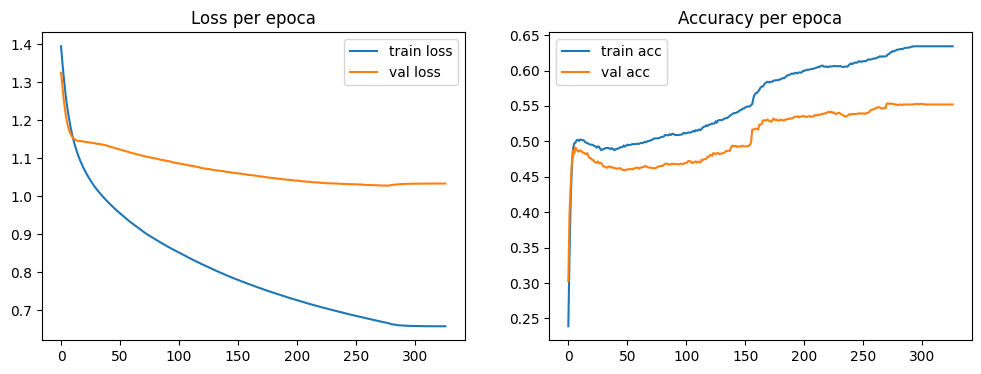

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification report (validation):
              precision    recall  f1-score   support

           0     0.8645    0.6139    0.7180       904
           1     0.2650    0.3605    0.3055       233
           2     0.2198    0.4959    0.3046       121
           3     0.0556    0.2000    0.0870        10

    accuracy                         0.5528      1268
   macro avg     0.3512    0.4176    0.3537      1268
weighted avg     0.6864    0.5528    0.5978      1268



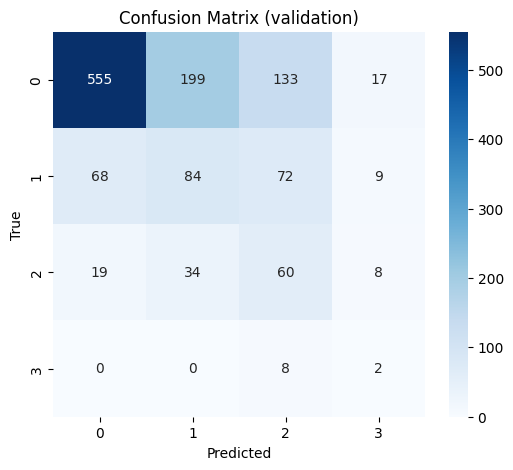

Recall classe severe (3): 0.2000


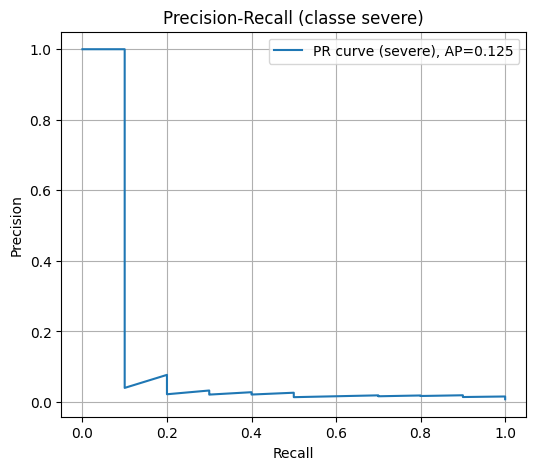

In [209]:
# rieseguo il modello con i dati imputati e standardizzati, sempre con i parametri di default
esegui_modello()


Rispetto al modello con `-9999`: 

- l'andamento delle accuracy per le varie epoche è più regolare
- sulla diagonale principale della confusion matrix vediamo subito un nettissimo miglioramento per la classe 2, mentre le altre 3 si nota un piccolo degrado delle prestazioni
- sempre guardando la confusion matrix, ci sono molte meno predizioni di classe 3, come numero assoluto, e molte di più della classe 2. Un lato positivo è che la di "true 3" nessuna è stata predetta come 0 o 1, e in un test medico è un buon risultato.
- la classe 0 resta la più riconosciuta, più o meno invariata anche se in leggero peggioramento  
- la classe 1 resta problematica 
- l'F1-score delle classi 2 e 3 migliora

in generale abbiamo avuto un leggero miglioramento, ma c'è ancora molto da fare.
Proviamo ora a modificare un po' i parametri della rete neurale. Userò una sola cella di codice, e in quella successiva metto i risultati mano a mano


{np.int64(0): np.float64(0.35081240768094535), np.int64(1): np.float64(1.3610315186246418), np.int64(2): np.float64(2.6243093922651934), np.int64(3): np.float64(29.6875)}
Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3195 - loss: 1.3986 - val_accuracy: 0.4290 - val_loss: 1.2788 - learning_rate: 0.0010
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4421 - loss: 1.2741 - val_accuracy: 0.5000 - val_loss: 1.1983 - learning_rate: 0.0010
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4589 - loss: 1.2423 - val_accuracy: 0.5126 - val_loss: 1.1560 - learning_rate: 0.0010
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4695 - loss: 1.2219 - val_accuracy: 0.5000 - val_loss: 1.1548 - learning_rate: 0.0010
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4679 - loss: 1.1682 - val_accuracy: 0.4866 - val_loss: 1.1455 - learning_rate: 0.0010
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4695 -

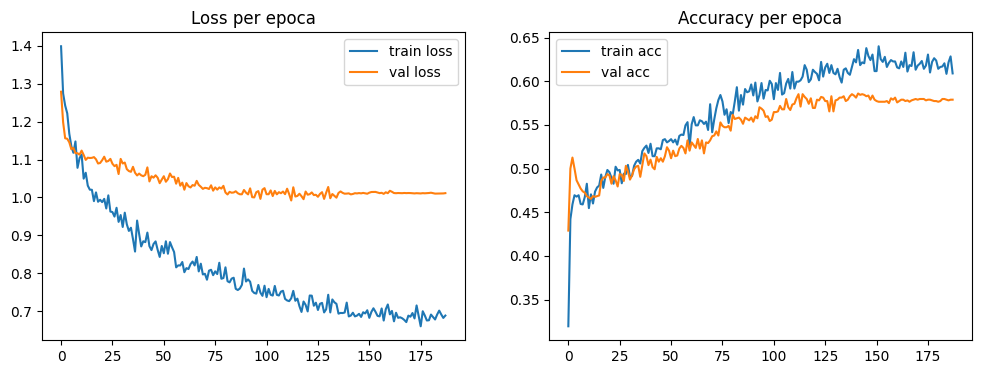

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification report (validation):
              precision    recall  f1-score   support

           0     0.8533    0.6626    0.7460       904
           1     0.2912    0.3262    0.3077       233
           2     0.2409    0.5455    0.3342       121
           3     0.0323    0.1000    0.0488        10

    accuracy                         0.5852      1268
   macro avg     0.3544    0.4086    0.3592      1268
weighted avg     0.6851    0.5852    0.6206      1268



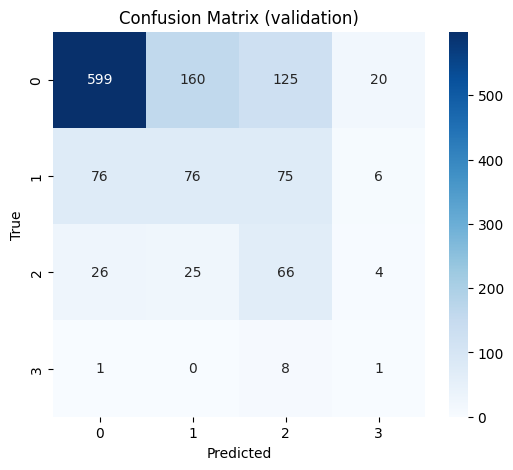

Recall classe severe (3): 0.1000


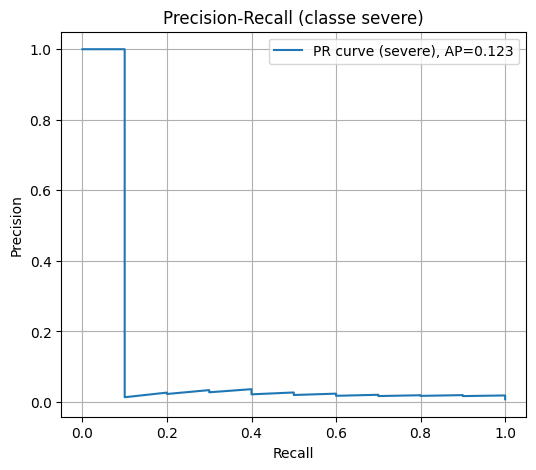

{np.int64(0): np.float64(0.35081240768094535), np.int64(1): np.float64(1.3610315186246418), np.int64(2): np.float64(2.6243093922651934), np.int64(3): np.float64(29.6875)}


In [ ]:
hidden_units=[64, 32]
activation='relu'
lr=1e-3
dropout=0.2 # dropout 20%
l2_reg=0
patience_early_stopping = 75
patience_reduce_lr = 25
factor = 0.2
min_lr=1e-6
epochs = 500
batch_size=64

# class_weights[0] = 1 
# class_weights[1] = 1 
# class_weights[2] = 1
# class_weights[3] = 1
print(class_weights)

esegui_modello(
    hidden_units=hidden_units,
    activation=activation,
    lr=lr,
    dropout=dropout,
    l2_reg=l2_reg,
    patience_early_stopping=patience_early_stopping,
    patience_reduce_lr=patience_reduce_lr,
    factor=factor,
    min_lr=min_lr,
    epochs=epochs,
    batch_size=batch_size
)
# ogni volta che cambio i pesi, se devo ristabilire quelli iniziali
# class_weights = {cls: w for cls, w in zip(classes, auto_weights)}
print(class_weights)

**1. lascio i parametri di default, aumento i pesi delle classi 2 (+10%) e 3 (+20%)**

il modello peggiora da ogni punto di vista

**2. lascio i parametri di default, ma tolgo totalmente i pesi**

L'ho fatto solo per conferma. Dal momento che la classe 0 è fortemente predominante, il modello risulta essere quasi equivalente alla moda vista come modello base, leggermente migliore, ma non si discosta troppo. Completamente sbagliato nella classe 3, che ha una sia la precision che la recall pari a 0.

**3. aumento numero di layer e neuroni, lascio intatto il resto ([128, 64, 32]). Provo a evitare overfitting**

1. la classe 0 aumenta sia di precision che di recall, stesso vale per la classe 1. le classi 2 e 3 invece calano. Anche la forma della confusion matrix è peggiorata, tendendo a favorire le prime due classi. 
Sono curioso adesso di vedere cosa succede se aumento ulteriormente il numero di neuroni, rendendo il modello più potente, aumentando anche la pazienza e il learning rate iniziale. Se aumenta ancora la capacità di predire le prime due classi, provo ad aumentare il peso delle altre, lasciando la struttura così "ingrandita". Siccome aumento molto la grandezza della rete neuronale, devo evitare l'overfitting, quindi vado a inserire anche un dropout casuale dell'1%

2. Come previsto, c'è un notevole overfitting, con accuracy sul training che schizza a quasi il 100% ma rimane stabile al 60 nel validation, con una loss che diverge. Posso provare ad aumentare il dropout per evitare overfitting, in quanto comunque anche sul validation le performance migliorano.

**4. torno sui miei passi e aumento solo il droupout**
1. aumentando il droupout al 20%, ho visto in generale migliorare le prestazioni. Sono tornato quindi sui miei passi. ho reimpostato i layer a [64, 32]. lasciando intatte le altre modifiche, e i risultati si sono rivelati più soddisfacenti dei precedenti:
   -  l'accuracy passa dal 53.9% del primo modello al 55.2% del secondo al 58.5 del terzo
   -  l'F1 delle classi 0 e 2 aumentano rispetto a entrambi i modelli (in particolare la classe 2, ha un aumento progressivo da 0.17 a 0.33), quello della classe 1 rimane stabile, a meno di qualche fluttuazione. 
   -  La classe 3 risulta invece problematica: la recall è calata sensibilmente (0.7 -> 0.2 -> 0.1), con la precision rimasta stabile, segno che il modello non è proprio in grado di catturarla. Il lato positivo è che 8 dei "true 2" sono stati classificati come 2, quindi non particolarmente distante, il lato negativo è che ci sono ancora 20 osservazioni classificate come 3 che in realtà sono di classe 0. quelle classificate come 3 ma appartenenti alle classi 1 e 2 sono invece diminuite, andando quindi a diminuire il false positive rate (che comunque è crollato rispetto al modello base).
   -  in generale, la media aritmetica dell'F1-score è aumentata, da 0.32 a 0.36, che è un buon segno, ed è aumentata anche la media ponderata, da 0.60 a 0.62, segno comunque di un complesivo miglioramento.  

2. lasciando intatte le modifiche fatte al punto precedente, provo ad aumentare leggermente i pesi delle classi 2 e 3, per vedere se il modello riesce a catturarle meglio. Dovrei aspettarmi un leggero calo dell'accuracy, perché le prestazioni si concentrano sulle classi minoritarie. -> Dopo svariati tentativi, modificando i moltiplicatori in tanti modi diversi, le prestazioni non sono mai migliorate, dal punto di vista di nessuna metrica.

per ora il miglior modello trovato ha questi iperparametri:
```
hidden_units=[64, 32]
activation='relu'
lr=1e-3
dropout=0.2 # dropout 20%
l2_reg=0
patience_early_stopping = 75
patience_reduce_lr = 25
factor = 0.2
min_lr=1e-6
epochs = 500
batch_size=64
```
   

# Cambio paradigma
Cosa potrei fare? data augmentation? ma con che dati? 
pensavo piuttosto a qualcosa del tipo "prima predico se è 0/1 0 2/3 (rispettivamente, non problematico e problematico), poi seleziono meglio tra le due classi"
In fondo, per lo scopo del progetto, se le classi 3 mi vengono predette come 2, non è sto grandissimo problema. È molto peggio se mi vengono predette come 1 o, peggio, 0.

# per dopo, alla fine di tutto
Alla fine, col test devo eseguire le stesse trasformazioni fatte sul train, per poterlo utilizzare (le stagioni devono diventare variabili numeriche, devo droppare le features usate per l'imputazione e devo standardizzare)

```py
X_test = X_test.drop(columns=proxy_features)

# rieseguo il mapping stagioni sul nuovo X_test
season_map = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}
season_cols = [col for col in X_test.columns if col.endswith('Season')]

for col in season_cols:
    X_test[col] = X_test[col].map(season_map)
```